In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

import random, os, pathlib, time
from tqdm import tqdm
from sklearn import datasets

In [2]:
# device = torch.device("cuda:1")
device = torch.device("cpu")

## 1D regression

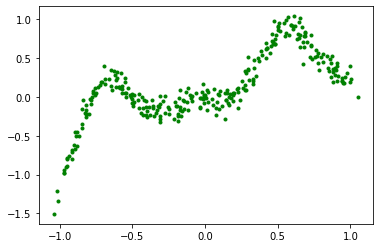

In [3]:
np.random.seed(12)
x = np.linspace(0,1,300)
noise = np.random.normal(0,0.02, x.shape)
x = x + noise
x = np.sort(x)

y= (2 * np.sin(10*x) + np.cos(20 * x - 3) + 3 * np.log(10*x + 0.5) - 4)/6.
noise = np.random.normal(0,0.1, x.shape)
y = y + noise

x = x*2
x = x - x.mean() # good practice to zero-center x in linear mapping
xx = torch.Tensor(x.reshape(-1,1))
yy = torch.Tensor(y.reshape(-1,1))

%matplotlib inline
plt.scatter(x, y, marker='.', color='g')
plt.show()

In [4]:
class DistanceTransform(nn.Module):
    
    def __init__(self, input_dim, num_centers):
        super().__init__()
        self.input_dim = input_dim
        self.num_centers = num_centers
        
        self.centers = torch.randn(num_centers, input_dim)/3.
        self.centers = nn.Parameter(self.centers)
        
    def forward(self, x):
        x = x[:, :self.input_dim]
        dists = torch.cdist(x, self.centers)
        return dists

In [5]:
inpDT = DistanceTransform(1, 2)
outDT = DistanceTransform(1, 2)

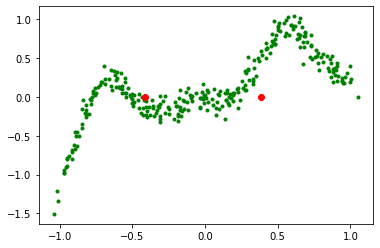

In [6]:
%matplotlib inline
ic = inpDT.centers.data#.reshape(-1)
plt.scatter(x, y, marker='.', color='g')
plt.scatter(ic, torch.zeros_like(ic), marker='o', color='r')
plt.show()

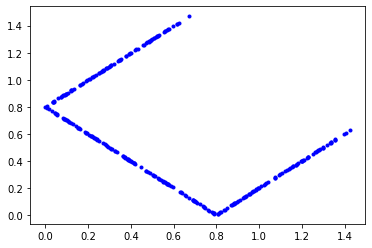

In [7]:
it = inpDT(xx).data
# plt.scatter(x, y, marker='.', color='g')
plt.scatter(it[:,0], it[:,1], marker='.', color='b')
plt.show()

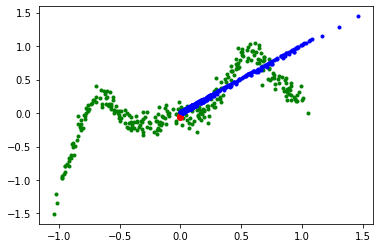

In [8]:
oc = outDT.centers.data#.reshape(-1)
ot = outDT(yy).data

plt.scatter(x, y, marker='.', color='g')
plt.scatter(torch.zeros_like(oc), oc, marker='o', color='r')
plt.scatter(ot[:,0], ot[:,1], marker='.', color='b')
plt.show()

## Only Positive weight network

In [170]:
class PositiveNet(nn.Module):
    
    def __init__(self, i=2, o=2):
        super().__init__()
        self.l1 = nn.Linear(i, 100)
#         self.a1 = nn.Softmax(dim=1)
        self.a1 = nn.ReLU()
        self.l2 = nn.Linear(100, 10)
#         self.a2 = nn.Softmax(dim=1)
        self.a2 = nn.ReLU()
        self.l3 = nn.Linear(10, o)
#         self.a3 = nn.Softmax(dim=1)
        
    def _preprocess_(self):
#         self.l1.weight.data = self.l1.weight.data.abs()
#         self.l1.bias.data = self.l1.bias.data.abs()
        
#         self.l2.weight.data = self.l2.weight.data.abs()        
#         self.l2.bias.data = self.l2.bias.data.abs()        

        self.l3.weight.data = self.l3.weight.data.abs()
        self.l3.bias.data = self.l3.bias.data.abs()
        
    def forward(self, x):
        self._preprocess_()
        x = self.a1(self.l1(x))
        x = self.a2(self.l2(x))        
        x = self.l3(x)
        return x
#         return self.a3(x)

In [171]:
posNet = PositiveNet(3,3)
inpDT = DistanceTransform(1, 3)
outDT = DistanceTransform(1, 3)

In [172]:
criterion = nn.MSELoss()
params = list(posNet.parameters())
params += list(inpDT.parameters())
params += list(outDT.parameters())

optimizer = optim.Adam(params,
                       lr = 0.001)

In [173]:
%matplotlib tk
fig = plt.figure()
ax = fig.add_subplot(111)

for epoch in range(100000):

    hi = posNet(inpDT(xx))
    ho = outDT(yy)
    
    error = criterion(hi, ho)
    optimizer.zero_grad()
    error.backward()
    optimizer.step()
    
    if epoch%100 == 0:
        
        error = float(error)
        print(epoch, 'Error = ', error)
        ax.clear()
        ax.scatter(hi.data[:,0], hi.data[:,1], marker='.', color='g')
        ax.scatter(ho.data[:,0], ho.data[:,1], marker='.', color='r')
        
        ic = inpDT.centers.data#.reshape(-1)
        ax.scatter(ic, torch.zeros_like(ic), marker='o', color='g')

        oc = outDT.centers.data#.reshape(-1)
        ax.scatter(torch.zeros_like(oc), oc, marker='o', color='r')
        

        fig.canvas.draw()
        plt.pause(0.01)

0 Error =  0.16333229839801788
100 Error =  0.05555977299809456
200 Error =  0.026837361976504326
300 Error =  0.012666501104831696
400 Error =  0.009593893773853779
500 Error =  0.008751823566854
600 Error =  0.008351527154445648
700 Error =  0.008018450811505318
800 Error =  0.007754650432616472
900 Error =  0.007609040010720491
1000 Error =  0.007493963930755854
1100 Error =  0.0073966942727565765
1200 Error =  0.007322499994188547
1300 Error =  0.0072552659548819065
1400 Error =  0.007196175865828991
1500 Error =  0.00712345726788044
1600 Error =  0.0070717064663767815
1700 Error =  0.006998957600444555
1800 Error =  0.0069174268282949924
1900 Error =  0.00684999767690897
2000 Error =  0.006712842732667923
2100 Error =  0.006535980850458145
2200 Error =  0.006479935720562935
2300 Error =  0.006418242119252682
2400 Error =  0.0063534206710755825
2500 Error =  0.006305570714175701
2600 Error =  0.00624828040599823
2700 Error =  0.006232180166989565
2800 Error =  0.00621819170191884
2

TclError: invalid command name "pyimage497"

In [165]:
### solve output with GD

In [192]:
_yy = yy.clone().to(device)
YY = torch.autograd.Variable(_yy, requires_grad=True)
# YY = torch.autograd.Variable(torch.rand_like(yy, device=device), requires_grad=True)

In [193]:
yoptim = torch.optim.RMSprop([YY], lr=0.001)

In [194]:
YY.shape, YY.device

(torch.Size([300, 1]), device(type='cpu'))

In [195]:
%matplotlib tk
fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(10000):
    yout = outDT(YY)
    error = ((hi.data-yout)**2).mean()
    yoptim.zero_grad()
    error.backward(retain_graph=True)
    yoptim.step()
    
    if i%100 == 0:
        print(f"Step: {i}, error: {error:.6f}")
        
        ax.clear()
        ax.scatter(x, y, marker='.', color='g')
        ax.scatter(x, YY.data, marker='.', color='r')
#         ax.show()

        fig.canvas.draw()
        plt.pause(0.01)

Step: 0, error: 0.006059
Step: 100, error: 0.000173
Step: 200, error: 0.000034
Step: 300, error: 0.000006
Step: 400, error: 0.000002
Step: 500, error: 0.000002
Step: 600, error: 0.000002
Step: 700, error: 0.000002
Step: 800, error: 0.000002
Step: 900, error: 0.000002
Step: 1000, error: 0.000002
Step: 1100, error: 0.000002
Step: 1200, error: 0.000002
Step: 1300, error: 0.000002
Step: 1400, error: 0.000002
Step: 1500, error: 0.000002
Step: 1600, error: 0.000002
Step: 1700, error: 0.000002
Step: 1800, error: 0.000002
Step: 1900, error: 0.000002
Step: 2000, error: 0.000002
Step: 2100, error: 0.000002
Step: 2200, error: 0.000002
Step: 2300, error: 0.000002
Step: 2400, error: 0.000002
Step: 2500, error: 0.000002
Step: 2600, error: 0.000002
Step: 2700, error: 0.000002
Step: 2800, error: 0.000002
Step: 2900, error: 0.000002
Step: 3000, error: 0.000002
Step: 3100, error: 0.000002
Step: 3200, error: 0.000002
Step: 3300, error: 0.000002
Step: 3400, error: 0.000002
Step: 3500, error: 0.000002
Step

TclError: invalid command name "pyimage566"

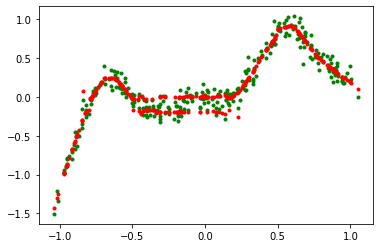

In [196]:
%matplotlib inline
plt.scatter(x, y, marker='.', color='g')
plt.scatter(x, YY.data, marker='.', color='r')
plt.show()